# PARAMETERS

In [64]:
# NOTINREPORT
%run ./src/Modules.ipynb   
changeParameters()


button = widgets.Button(description="Save parameters")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    np.savetxt( './src/parameters.csv',
            [[sampleName_p.value,previousPowerOf2(int(min(10, measureDuration_p.value)* 125e6 / 16384)) * 16384 / 125e6, Rload_p.value, nbCycles_p.value, Rcircuit_p.value, fourrierMaxFreq_p.value]],
            delimiter=",",
            fmt='%s',
            header = 'Sample name, Measure duration, Rload, Nb Periods, R Circuit, Max Frequency'
            )
        
button.on_click(on_button_clicked)

Button(description='Save parameters', style=ButtonStyle())

Output()

In [65]:
### Print sample name and define folder
parameters = np.loadtxt('./src/parameters.csv', delimiter=",", comments='#', dtype=str)
sampleName = parameters[0]

folder = './data/{}/{}_{}/{}/{}h{}/{}/'.format(date.today().strftime('%Y'), date.today().strftime('%m'), date.today().strftime('%B'), date.today().strftime('%d'), str(time.localtime().tm_hour).zfill(2), str(time.localtime().tm_min).zfill(2), sampleName)

print('Sample name: ' + str(sampleName))

Sample name: ES.PVDF.E0.0m.100nm


In [66]:
### Print parameters

parameters = np.loadtxt('./src/parameters.csv', delimiter=",", comments='#', dtype=str)

measureDuration = float(parameters[1])
Rload = float(parameters[2])
nbCycles = float(parameters[3])
Rcircuit = float(parameters[4])
fourrierMaxFreq = float(parameters[5])

pd.DataFrame(   np.array([
                ['Sample name', 'Measure duration', 'Rload', 'Nb Periods', 'R Circuit', 'Max Frequency'],
                parameters,
                ['', '[s]', '[Ohms]', '[1]', '[Ohms]', '[Hz]'] ]).transpose(),
                columns=['Parameter', 'Value', 'Unit'],
            )

,Parameter,Value,Unit
0,Sample name,ES.PVDF.E0.0m.100nm,
1,Measure duration,8.589934592,[s]
2,Rload,1000000.0,[Ohms]
3,Nb Periods,3.0,[1]
4,R Circuit,1.0,[Ohms]
5,Max Frequency,100.0,[Hz]


# PRESSURE AND VOLTAGE MEASUREMENTS

The input frequency is: 27.13 Hz


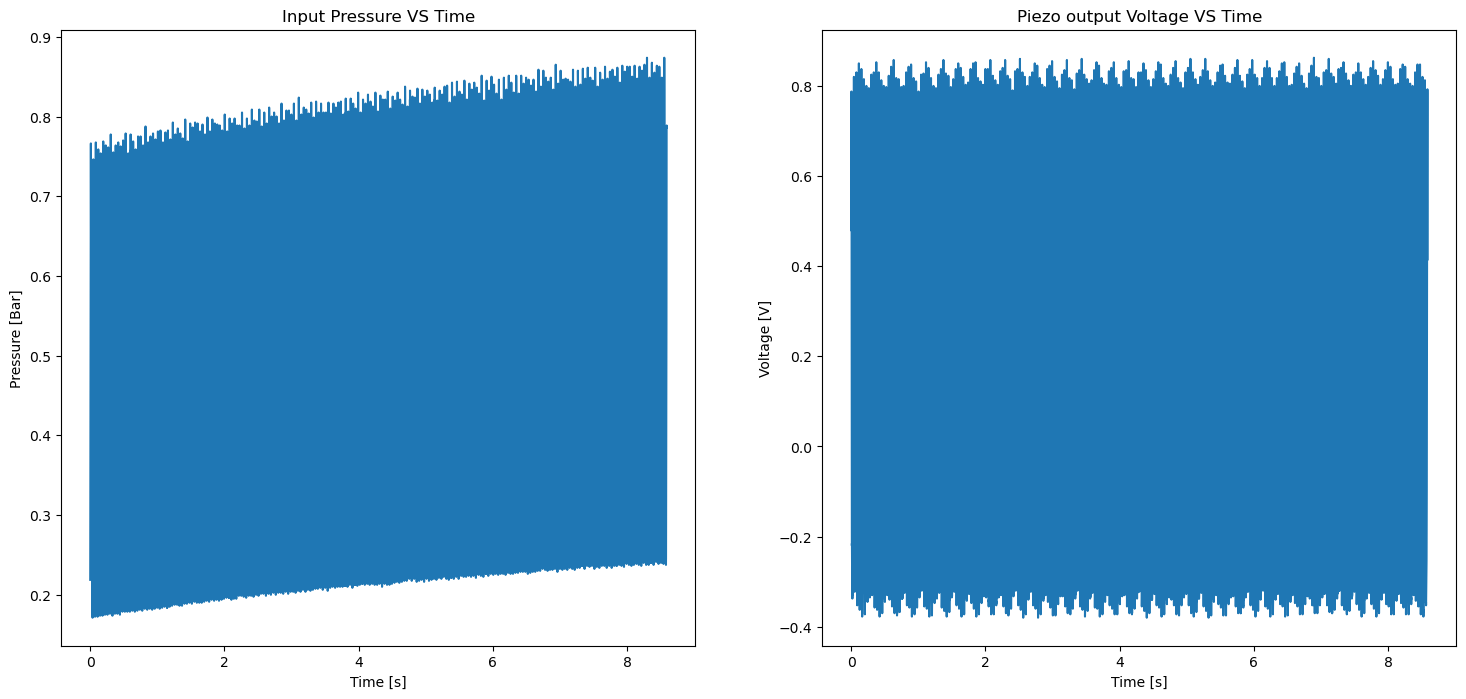

In [67]:
# Perform measurements
# Update the folder with the date/time of the experiment
folder              = './data/{}/{}_{}/{}/{}h{}/{}/'.format(date.today().strftime('%Y'), date.today().strftime('%m'), date.today().strftime('%B'), date.today().strftime('%d'), str(time.localtime().tm_hour).zfill(2), str(time.localtime().tm_min).zfill(2), sampleName)

voltage, pressure   = getRFInputs(measureDuration)                                          # Get data from RedPitaya
pressure.y          /= 2                                                                    # Convert from V to Bar

pressure.FourierTransform(fourrierMaxFreq)                                                  # Perform Fourier transform on pressure
voltage.FourierTransform(fourrierMaxFreq)                                                   # Perform Fourier transform on voltage
print('The input frequency is: {:5.2f} Hz'.format(pressure.getFrequency()))                 # Find excitation frequency and print it

graphVoltage        = graph(    voltage.t,   voltage.y,                                     # Define voltage graph
                                'Time [s]', 'Voltage [V]', 'Piezo output Voltage VS Time')
graphPressure       = graph(    pressure.t, pressure.y,                                     # Define pressure graph
                                'Time [s]', 'Pressure [Bar]', 'Input Pressure VS Time')

plotGraph([graphPressure], [graphVoltage], 'InputOutputFull')                               # Plot graph and save it                              

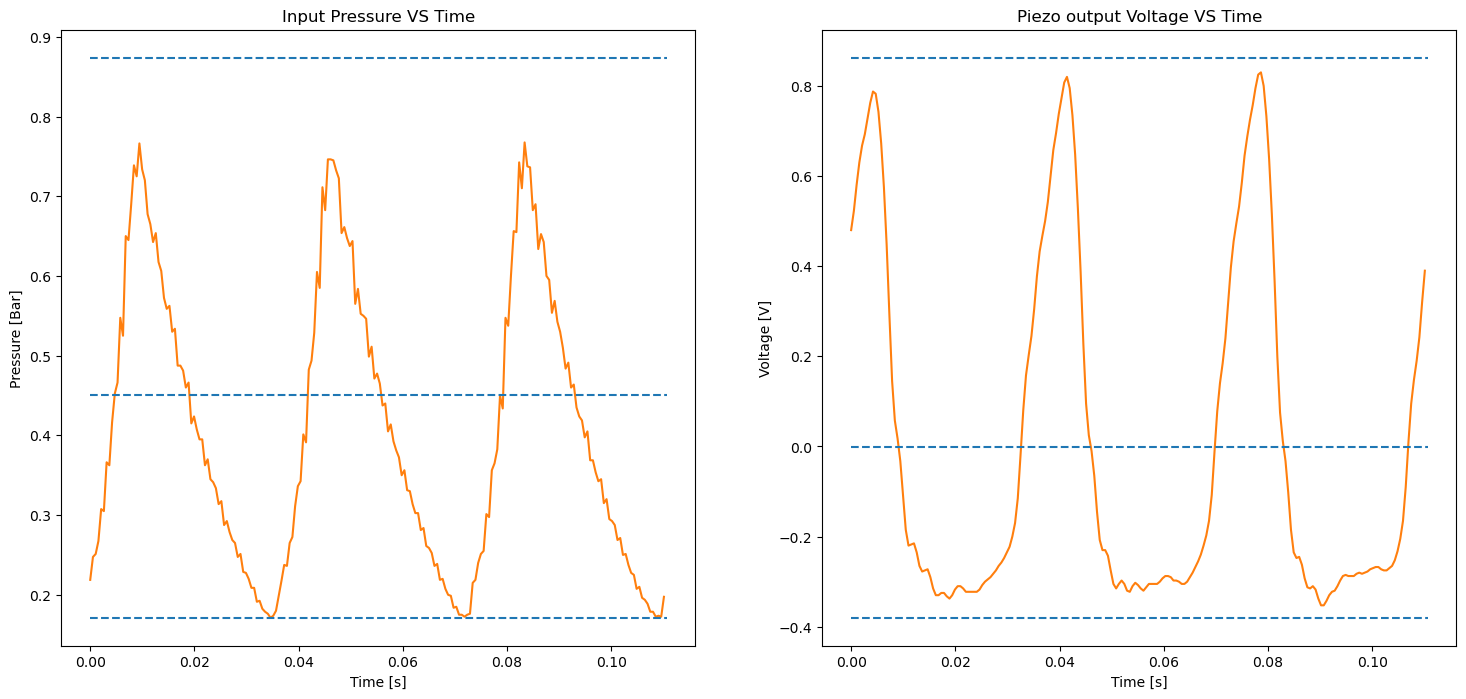

In [68]:
### Plot measurements cropped to the first periods
period, period_sec  = pressure.find_period( nbCycles )                                      # Find the period (index and in sec) of the input

graphVoltageCropped = graph( voltage.t[:period],    voltage.y[:period],                     # Define the cropped voltage graph
                        'Time [s]', 'Voltage [V]',      'Piezo output Voltage VS Time', color='C1')
graphPressureCropped= graph( pressure.t[:period],   pressure.y[:period],                    # Define the cropped pressure graph
                        'Time [s]', 'Pressure [Bar]',   'Input Pressure VS Time',       color='C1')


plotGraph(  [ graphPressureCropped,                                                          # Plot graph with mean value and maxima
            graph([ 0, period_sec ], [ max(pressure.y), max(pressure.y) ],          symbol='--'),
            graph([ 0, period_sec ], [ np.mean(pressure.y), np.mean(pressure.y) ],  symbol='--'),
            graph([ 0, period_sec ], [ min(pressure.y), min(pressure.y) ],          symbol='--')],
            [ graphVoltageCropped, 
            graph([ 0, period_sec ], [ max(voltage.y), max(voltage.y) ],            symbol='--'),
            graph([ 0, period_sec ], [ np.mean(voltage.y), np.mean(voltage.y)],     symbol='--'),
            graph([ 0, period_sec ], [ min(voltage.y), min(voltage.y) ],            symbol='--')],
            'InputOutput{}periods'.format(nbCycles))

In [69]:
pd.DataFrame(   np.array([
                [ 'Pressure [Bar]', '%0.2e'%np.min(pressure.y), '%0.2e'%np.max(pressure.y), '%0.2e'%(np.max(pressure.y)-np.min(pressure.y)), '%0.2e'%np.mean(pressure.y), '%0.2e'%np.mean(abs(pressure.y)) ],
                [ 'Voltage [V]', '%0.2e'%np.min(voltage.y), '%0.2e'%np.max(voltage.y), '%0.2e'%(np.max(voltage.y)-np.min(voltage.y)), '%0.2e'%np.mean(voltage.y), '%0.2e'%np.mean(abs(voltage.y)) ]
                ]),
                columns= ['Variable', 'Min', 'Max', 'Peak to peak', 'Mean', 'Mean of absolute value']
            )

,Variable,Min,Max,Peak to peak,Mean,Mean of absolute value
0,Pressure [Bar],1.71e-01,8.74e-01,7.03e-01,4.51e-01,4.51e-01
1,Voltage [V],-3.80e-01,8.63e-01,1.24e+00,-8.63e-04,3.35e-01


# POWER

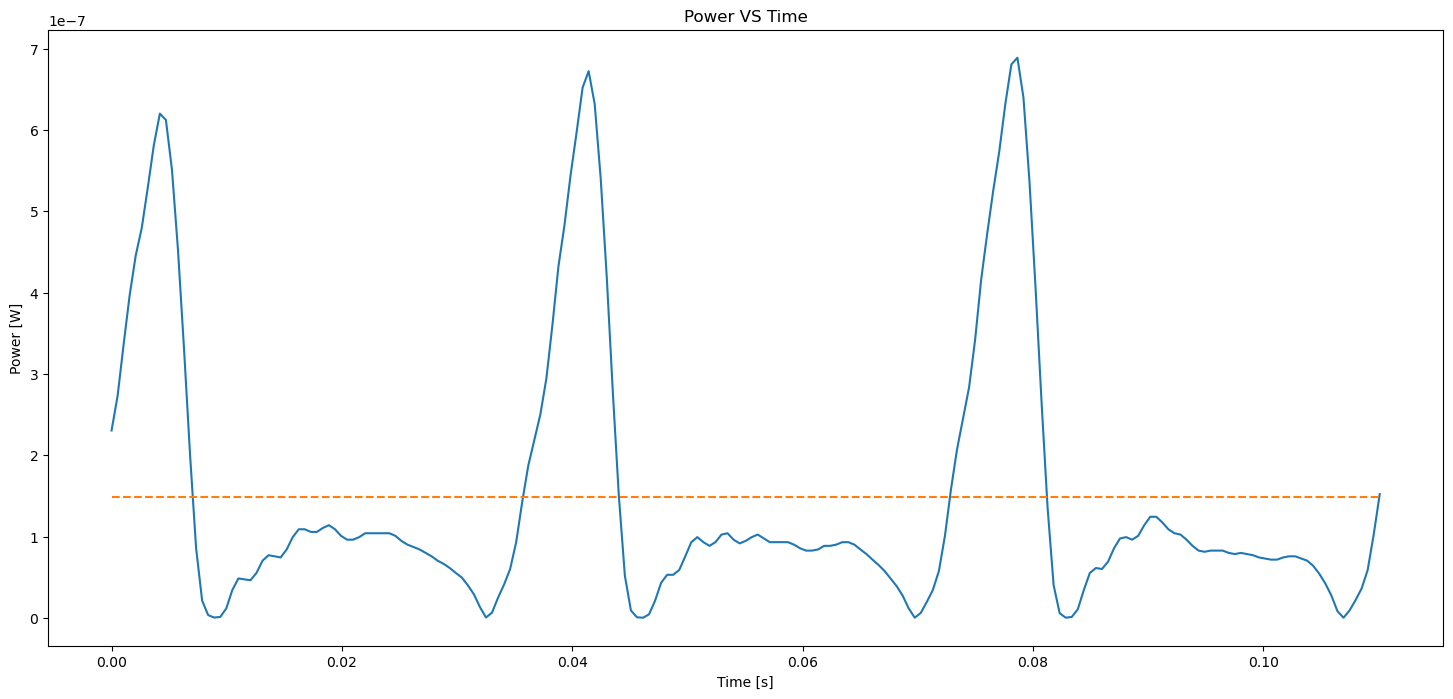

Mean power: 1.49e-07 [W]


In [70]:
### Compute power using Ohm's law
power               = data( voltage.t[ : period ], voltage.y[ : period ] ** 2 / ( Rload + Rcircuit ))   

graphPower          = graph( power.t, power.y, 'Time [s]', 'Power [W]', 'Power VS Time' )   # Define power graph
graphPowerAverage   = graph( [ 0, np.max(power.t) ], [ np.mean(power.y), np.mean(power.y) ], symbol='--', color='C1')

plotGraph([ graphPower, graphPowerAverage ], None, 'Power')                                 # Plot graph and save it

print('Mean power: %0.2e [W]'%(np.mean(power.y)))                                           # Print mean value

# FREQUENCY ANALYSIS

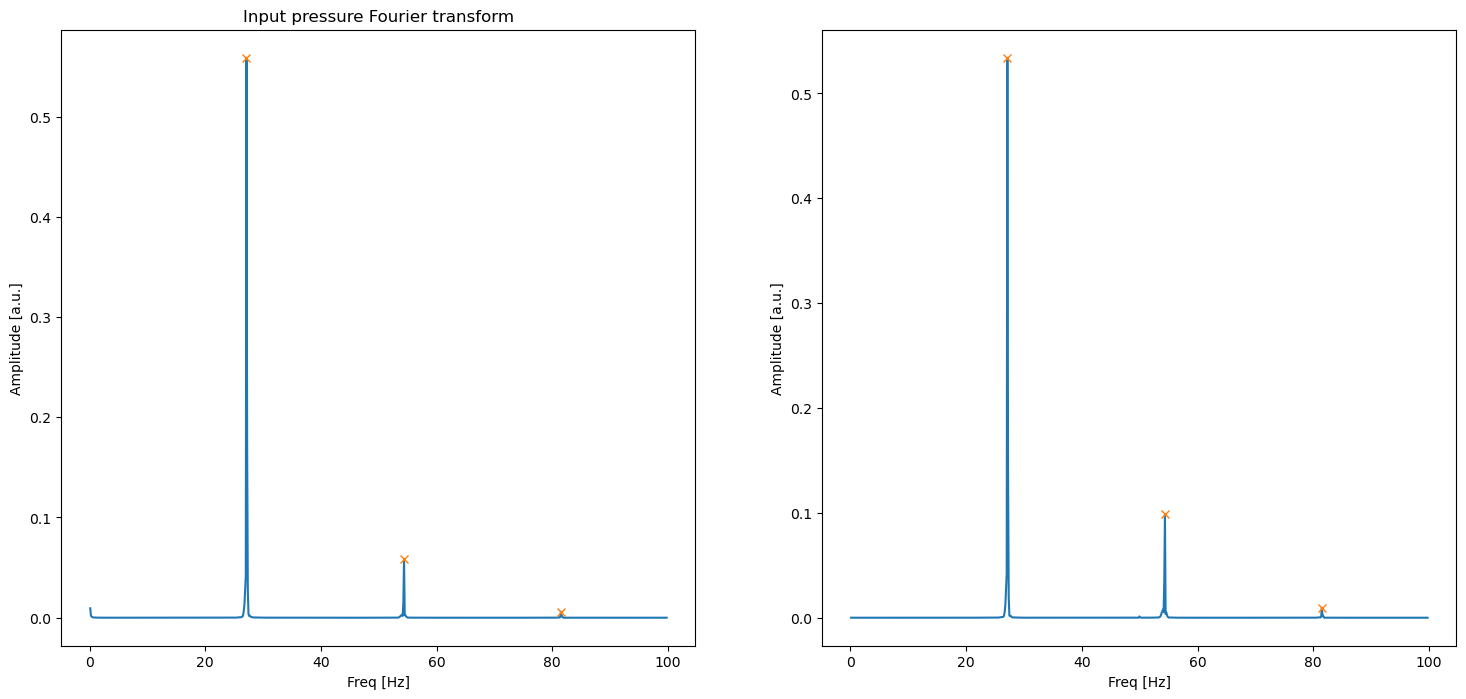

In [71]:
### Plot input pressure and piezo voltage in the frequency domain 
### Find peaks on the Fourier transform
pressure.FourierTransform(fourrierMaxFreq)                                                  # Perform Fourier transform on pressure
voltage.FourierTransform(fourrierMaxFreq)  
voltagePeaks        = signal.find_peaks( np.real(voltage.ampFT), prominence=max( np.real(voltage.ampFT) ) / 100, distance = 5 )[0]
pressurePeaks       = signal.find_peaks( np.real(pressure.ampFT), prominence=max( np.real(pressure.ampFT )) / 100, distance = 5)[0]

### Extract the peak around 50Hz and delete it
Peak50              = find_nearest( voltagePeaks, find_nearest(voltage.freq, 50) )
Hz50                = voltagePeaks[ Peak50 ]

### Define the graphs with a different color around the 50Hz peak
if 49<voltage.freq[Hz50]<51:
    voltagePeaks        = np.delete( voltagePeaks, Peak50 )
    graphVoltageFT      = graph( np.concatenate((voltage.freq[:Hz50-5], voltage.freq[Hz50+5:])), np.conjugate(np.concatenate((voltage.ampFT[:Hz50-5],voltage.ampFT[Hz50+5:]))),
                                'Freq [Hz]', 'Amplitude [a.u.]', 'Piezo voltage Fourier transform')
    graphVoltageFTHz50  = graph( voltage.freq[Hz50-5:Hz50+5], voltage.ampFT[Hz50-5:Hz50+5],
                                'Freq [Hz]', 'Amplitude [a.u.]', color='r')
else :
    graphVoltageFT      = graph( voltage.freq, voltage.ampFT,
                            'Freq [Hz]', 'Amplitude [a.u.]')

graphPressureFT     = graph(pressure.freq, pressure.ampFT,
                            'Freq [Hz]', 'Amplitude [a.u.]', 'Input pressure Fourier transform')

### Define dots
graphVoltagePeaks   = graph(voltage.freq[voltagePeaks], voltage.ampFT[voltagePeaks], symbol='x', color='C1')

graphPressurePeaks  = graph(pressure.freq[pressurePeaks], pressure.ampFT[pressurePeaks], symbol='x', color='C1')

### Plot graph and save it
if 49<voltage.freq[Hz50]<51:
    plotGraph([graphPressureFT, graphPressurePeaks], [graphVoltageFT, graphVoltageFTHz50, graphVoltagePeaks], 'FourierTransform')
else:
    plotGraph([graphPressureFT, graphPressurePeaks], [graphVoltageFT, graphVoltagePeaks], 'FourierTransform')

## Voltage frequency peaks

In [72]:
pd.DataFrame(   np.array([
                ['%0.2f'%i for i in np.real(voltage.freq[voltagePeaks]) ],
                ['%0.2f'%i for i in np.real(voltage.ampFT[voltagePeaks]*100)]
                ]).transpose(),
                columns = ['Freq [Hz]', 'Amplitude percentage']
            )

,Freq [Hz],Amplitude percentage
0,27.13,53.41
1,54.37,9.88
2,81.50,0.95


## Pressure frequency peaks

In [73]:
pd.DataFrame(   np.array([
                ['%0.2f'%i for i in np.real(pressure.freq[pressurePeaks])],
                ['%0.2f'%i for i in np.real(pressure.ampFT[pressurePeaks])*100]
                ]).transpose(),
                columns = ['Freq [Hz]', 'Amplitude percentage']
)

,Freq [Hz],Amplitude percentage
0,27.13,55.87
1,54.37,5.85
2,81.50,0.61


In [74]:
# NOTINREPORT
time.sleep(2)
if sampleName == '': sampleName = 'untitled'
if os.path.exists(folder+sampleName+'.data.csv') or os.path.exists(folder+sampleName+'.report.pdf'):
    raise NameError('Files {} or {} already exist in folder {}, please change sample name!'.format(sampleName+'.data.csv',sampleName+'.report.pdf', folder, ))
else:
    saveNotebook()
    exportData = [pressure.t, pressure.y, voltage.y]
    exportHeader = "t [s], pressure [Bar], voltage [V]"
    %run ./src/SaveFiles.ipynb